<a href="https://colab.research.google.com/github/vondersam/sdgs_text_classifier/blob/master/experiments/sdgs_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive

     |████████████████████████████████| 993kB 36.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
pre = drive.CreateFile({'id':'1ojX1O9ifhZdT78l5mcD-Ctx6yapF7T5o'})
pre.GetContentFile('preprocess.ipynb')

In [0]:
from preprocessing import count_mas

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
base_dir = "gdrive/My Drive/fastai-v3/sdgs/"
dataset_dir = base_dir + "lstm/"

Mounted at /content/gdrive


In [0]:
from fastai.text import *

## Uploading the data

In [3]:
source_path = Path(dataset_dir + 'cleanup_labelled.csv')
df = pd.read_csv(source_path)
df.head()

,text,labels,doc_id
0,Goal 8: Decent work and economic growth,8,downloadable_pdfs/http:__www.dev.sdgfund.org_%...
1,The day after receiving the 2016 Pritzker Laur...,11,downloadable_pdfs/http:__www.dev.sdgfund.org_a...
2,"For Paloma Duran, SDG Fund director, this proj...",16,downloadable_pdfs/http:__www.dev.sdgfund.org_b...
3,"Rangita de Silva, Associate Dean of the Univer...",5,downloadable_pdfs/http:__www.dev.sdgfund.org_b...
4,"The SDG Fund, an interagency mechanism establi...",16,downloadable_pdfs/http:__www.dev.sdgfund.org_b...


We first create a general language model with the unlabelled data, which we will later fit into the WikiText 103 language model, so that it has more information about SDGs.

In [0]:
#data_lm = TextLMDataBunch.from_csv(dataset_dir, 'cleanup_unlabelled.csv')

In [0]:
#data_lm.show_batch()
#data_lm.save('data_lm_export.pkl')
path = Path(dataset_dir)
data_lm = load_data(path, 'data_lm_export.pkl')

In [20]:
data_lm

TextLMDataBunch;

Train: LabelList (198642 items)
x: LMTextList
xxbos themes of the xxmaj commission where science has been effectively employed to support the,xxbos xxmaj promote and support efforts and initiatives to secure equitable access to land tenure and clarify resource rights and responsibilities , through land and tenure reform processes that respect the rule of law and are enshrined in national law , and provide access to credit for all , especially women , and that enable economic and social empowerment and poverty eradication as well as efficient and ecologically sound utilization of land and that enable women producers to become decision makers and owners in the sector , including the right to inherit land ;,xxbos xxmaj the paper is structured as follows : xxmaj section 2 presents the methodology used xxmaj section 3 describes our overall findings – an analysis of the use of targets and the degree of additional stretch that the sdgs would require xxmaj section 4 provides 

# Training the general language model

We train on the first layer of the language model with all the data and a pretrained language model from the WikiText 103. This is included in the architecture of AWD_LSTM.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


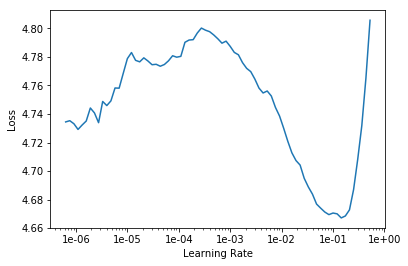

In [21]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [0]:
#learn.save('fit_head')

In [12]:
#learn.load('fit_head')

AttributeError: ignored

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [0]:
learn.save_encoder('fine_tuned_encoder')

In [0]:
#learn.load_encoder('fine_tuned_encoder')

In [12]:
learn.predict("African countries like", n_words=20)

'African countries like Nigeria in South Africa , Zimbabwe , and Southeast Asia in the United'

# Training the classifier

Then we load the language model for the classifier

In [0]:
!ls gdrive/'My Drive'/fastai-v3/sdgs/lstm/

cleanup_labelled.csv	data_clas_export.pkl  models
cleanup_unlabelled.csv	data_lm_export.pkl


In [0]:
data_clas = TextClasDataBunch.from_csv(dataset_dir, 'cleanup_labelled.csv', vocab=data_lm.train_ds.vocab, bs=32, text_cols='text', label_cols="labels", label_delim="|")

In [0]:
data_clas.save('data_clas_export.pkl')

In [0]:
#data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [0]:

F1 = partial(MultiLabelFbeta, average="macro")
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, callback_fns=[F1])
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


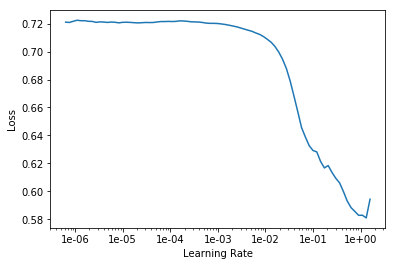

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,macro_fbeta,time
0,0.244128,0.195901,0.328000,00:13


In [0]:
learn.save('first')

In [0]:
learn.load('first')

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,macro_fbeta,time
0,0.190883,0.177494,0.454085,00:14


In [0]:
lear.save('second')

In [0]:
lear.load('second')

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8, 0.7))

In [0]:
learn.save('third')

In [0]:
learn.load('third')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=0.8,0.7)

epoch,train_loss,valid_loss,macro_fbeta,time
0,0.171165,0.172345,0.526257,00:31
1,0.165512,0.161713,0.573937,00:33
2,0.147813,0.155927,0.620684,00:33
3,0.132138,0.145209,0.661952,00:35
4,0.115479,0.138546,0.706803,00:35
5,0.104471,0.135142,0.740528,00:35
6,0.095513,0.134996,0.763007,00:33
7,0.085548,0.135496,0.782925,00:31
8,0.078873,0.135753,0.786783,00:34
9,0.080727,0.135264,0.796248,00:32


In [0]:
learn.save('fourth')

In [0]:
learn.load('fourth')

In [0]:
learn.show_results(rows=500)

text,target,prediction
"xxbos xxup unossc , nest , xxmaj southern xxmaj voice , xxmaj reality of xxmaj aid , xxup undp and xxmaj mexico xxmaj south - xxmaj south cooperation ( xxup ssc ) has played an ever - increasing role in overcoming national , regional and global developmental challenges and is now a key enabler for achieving 2030 xxmaj agenda and other xxmaj internationally xxmaj agreed xxmaj development xxmaj goals .",5,17;4
"xxbos xxmaj only five countries ( xxmaj bangladesh , xxmaj china , xxmaj indonesia , xxmaj korea and xxmaj poland ) had statements expressing sub - goal 1.2 . xxmaj these range from general statements such as “ a prosperous xxmaj indonesia ” and “ secure national sustainable development ” ( xxmaj korea ) ; to more specific ones such as eradication of extreme poverty ( xxmaj bangladesh ) ,",1,1;10
"xxbos xxmaj table 3 : xxmaj targets and indicators for xxup sdg 11 xxmaj target description xxmaj core indicator xxmaj tier 11.1 xxmaj by 2030 , ensure access for all to adequate , safe and affordable housing and basic services and upgrade slums xxunk xxmaj proportion of urban population living in slums , informal settlements or inadequate housing i 11.2 xxmaj by 2030 , provide access to safe , affordable",1;11,11
"xxbos xxmaj sub - xxmaj goal 8.1 : xxmaj everyone has access to sufficient energy and consumption is efficient and sustainable . xxmaj access to energy is mainly a developing country issue , and attaining full electrification appears as a goal ( xxmaj bangladesh and xxmaj india ) . xxmaj however , access to renewables is relevant for all , and many countries identify related goals and targets ( xxmaj",8,7
"xxbos 31 xxmaj for xxup sdg1 in xxmaj africa , xxup rri has roles in probing the magnitude of the key factors feeding the incidence and depth of poverty in the region including high income inequality and illiteracy . xxmaj on the other hand , the key drivers that significantly reduce poverty in the region will need to be collectively xxunk through xxup rri . xxmaj these include higher levels",2;3,1;3
"xxbos xxmaj settlements infrastructure and xxmaj settlements with their infrastructure are liveable , green and well managed . 5.1 xxmaj all people have a home and access to basic infrastructure and services . 5.2 xxmaj urban planning provides liveable cities with clean air and efficient use of land and resources . 5.3 xxmaj major infrastructure development does not impose risk to the integrity of natural ecosystems and society , and",5;7,11
"xxbos 74 xxmaj the xxmaj least xxmaj developed xxmaj countries xxmaj report 2016 xxmaj income - only graduates have a much weaker manufacturing base than those graduating based on two criteria . xxmaj agriculture accounts for 46.6 per cent of employment in the ldcs projected to graduate by 2024 , but 68.1 per cent in other ldcs . xxmaj the projected graduations further increase the importance of rural economic transformation",1,1
"xxbos xxmaj like the ipoa , xxup sdg 17.12 emphasizes the realization of timely implementation of duty - free and quota - free market access on a lasting basis for all ldcs , consistent with the xxmaj world xxmaj trade xxmaj organization decisions , including by ensuring that preferential rules of origin applicable to imports from ldcs are transparent and simple and contribute to facilitating market access . xxmaj the",10;17;8,17
xxbos xxup long xxup term 1999–2014 xxup short xxup term 2009–2014 xxmaj common birds xxmaj farmland birds ( xxup sdg 2 ) xxmaj common birds xxmaj farmland birds ( xxup sdg 2 ) xxmaj the common bird index integrates the abundance and the diversity of a selection of common bird species associated with specific habitats . xxmaj rare species are not included . xxmaj three groups of bird species are,2,
xxbos xxup challenges xxmaj the xxmaj global xxmaj status xxmaj report on xxmaj violence xxmaj prevention 2014 and the xxmaj report on xxmaj global and xxmaj regional xxmaj estimates of xxmaj violence xxmaj aga